# Multi-Arm Bandit notes:

### Bandit Algorithms For Website Optimization - By John Myles White

### Traditional A/B testing: 

For example if we have two website designs, A and B, A/B testing refers to a paradigm of running 
    randomized controlled experiment where we would assign randomly traffic to design A and design B (may be a 50-50 split or 
    variations of A-A-B-B with some split of traffic mostly driven by resources in hand). Presumably, we would do some sample size studies to determine how many clicks / impressions we want before we make a final decision about the design. Generally we would do a hypothesis test by computing test statistic of some sort (some form of signal-to-noise ratio) with some distributional assumptions about the test statistic (e.g. normal approaximation of binomial etc.)


### Problems of traditional A/B testing:

1) We need to make sure that the traffic split is truely random to ensure that any other factors than the control and treatment get nullified by randomness. Sometimes it is impossible to ensure this.

2) Assumption of discrete decision boundary. So there is either exploration or exploitation. You either waste resources on bad design or not explore choices making premature decison about the best design.

3) You have to wait until the experiment is finished. Generally sample size calculations are dependent on non-intuitive concepts such as error 1 (reject null hypothesis when actually it is true) or error 2 (accept null hypothesis when actually false). Generally for low errors, if expectated conversion rates are too low (which in practice they are) power calculations result in very large sample sizes making it impractical to wait that long and waste those many resources.

## Multi-arm bandit algorithms:

1) Generally multi-arm bandit algorithms are introduced to solve the so called explore-exploit dilemma

2) Generally they smoothly transition from pure exploration to exploitation based on observed data and quantified uncertainty around the observed data

# Algorithm 1 - Epsilon-greedy algorithm

In simple terms:
- With probability (1-$\epsilon$) __exploit__ best known option
- With probability ($\epsilon$ / 2) __explore__ best known option
- With probability ($\epsilon$ / 2) __explore__ worst known option

- Each option is a arm of multi-arm bandit
- Reward is a quantitative measure of success
- Bandit is slot machine with many arms or options. Each arm has an associated reward with it
- Everytime we pull an arm, 2 things happen:
    - we miss out on any information about other arms we did not pull
    - And potentially (worst case) we lose any higher reward from arms which we did not pull
    - However, we do get feedback about the arm we pulled
    


In [1]:
import bandits as bandit
import time
import matplotlib.pyplot as plt
%matplotlib inline

def draw_charts(result_df, params, algo_name):
    plt.figure()
    
    params = params if params else ['']

    for eps in params:
        plt.plot(list(result_df.loc[eps,]['prob_of_best_arm'].index.values), list(result_df.loc[eps,]['prob_of_best_arm'].values), label='{0} + -param:{1}'.format(algo_name, eps))
    
    plt.xlabel('times')
    plt.ylabel('probability')
    plt.title('Probability of best arm')    
    plt.legend(loc='lower right')   

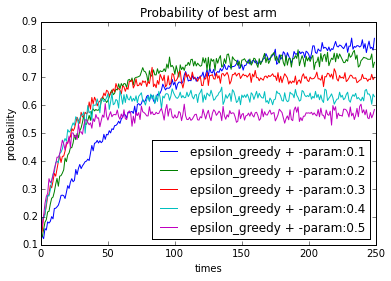

In [3]:
epsilon_greedy_df = bandit.run_bandit_algorithm_and_generate_results(algo_name='epsilon_greedy', params=[0.1,0.2,0.3,0.4,0.5], sim_nums=1000, times=250)
draw_charts(epsilon_greedy_df, params = [0.1,0.2,0.3,0.4,0.5], algo_name='epsilon_greedy')

# Algorithm 2 - Softmax Algorithm

Proportional sampling - https://en.wikipedia.org/wiki/Fitness_proportionate_selection
For arm selection this algorithm chooses proportional sampling (proportional to value estimate)

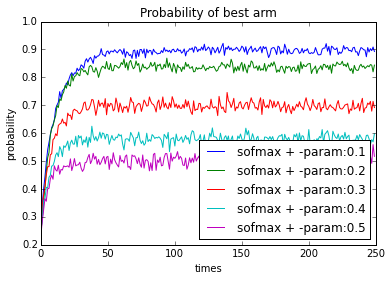

In [2]:
softmax_df = bandit.run_bandit_algorithm_and_generate_results(algo_name='softmax', params=[0.1,0.2,0.3,0.4,0.5], sim_nums=1000, times=250)
draw_charts(softmax_df, params = [0.1,0.2,0.3,0.4,0.5], algo_name='sofmax')

# Algorithm 3 - Softmax with anealling

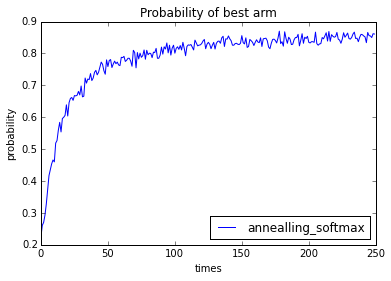

In [3]:
annealling_softmax_df = bandit.run_bandit_algorithm_and_generate_results(algo_name='Annealing_softmax', params=[], sim_nums=1000, times=250)
plt.figure()

plt.plot(list(annealling_softmax_df.loc[0]['prob_of_best_arm'].index.values), list(annealling_softmax_df.loc[0]['prob_of_best_arm'].values), label='annealling_softmax')
plt.xlabel('times')
plt.ylabel('probability')
plt.title('Probability of best arm')    
plt.legend(loc='lower right')

# Algorithm 4 - UCB

Compute uncertainty estimate for each arm and update value estimate by mean + uncertainty
uncertainty estimate = math.sqrt((2*math.log(total_counts))/arm.count)
This is really Chernoff-Hoeffding bound (http://jeremykun.com/2013/04/15/probabilistic-bounds-a-primer/)
and hence the name upper_confidence_bound

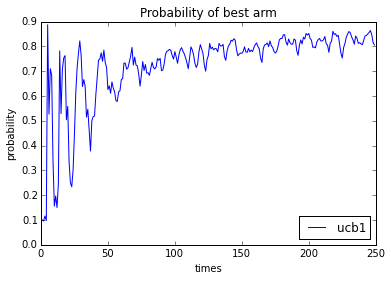

In [4]:
ucb_df = bandit.run_bandit_algorithm_and_generate_results(algo_name='ucb1', params=[], sim_nums=1000, times=250)
plt.figure()

#plt.plot(list(annealling_softmax_df.loc[0]['prob_of_best_arm'].index.values), list(annealling_softmax_df.loc[0]['prob_of_best_arm'].values), label='annealling_softmax')
plt.plot(list(ucb_df.loc[0]['prob_of_best_arm'].index.values), list(ucb_df.loc[0]['prob_of_best_arm'].values), label='ucb1')

plt.xlabel('times')
plt.ylabel('probability')
plt.title('Probability of best arm')    
plt.legend(loc='lower right')